<a href="https://colab.research.google.com/github/cheikhAbd/Sentiment_Analysis_Arabic/blob/main/Sentiment_Analysis_Arabic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Définition d'une variable d'environnement kaggle**


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

## **Installation du dataset**


In [ ]:
!pip install --upgrade xlrd

In [ ]:
!kaggle competitions download -c arabic-sentiment-analysis-2021-kaust

In [ ]:
!unzip /content/2.Egyptian\ Tweets.xlsx.zip -d /content/

## **Importation des Bibliothèques**


In [115]:
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import sys
import re
from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline

## **Chargement des Données d'Entraînement**


In [89]:
## Dataframe pour l'entraînement
df_train_neg = pd.read_csv('Dataset/train_Arabic_tweets_negative_20190413.tsv', sep='\t')
df_train_pos = pd.read_csv('Dataset/train_Arabic_tweets_positive_20190413.tsv', sep='\t')

## **Chargement des Données de Test**


In [92]:
# dataframe pour la test
df_test_neg = pd.read_csv('Dataset/test_Arabic_tweets_negative_20190413.tsv', sep='\t')
df_test_pos = pd.read_csv('Dataset/test_Arabic_tweets_positive_20190413.tsv', sep='\t')

# Supprimer les lignes avec des valeurs manquantes
df_train_neg = df_train_neg.dropna()
df_train_pos = df_train_pos.dropna()
df_test_neg = df_test_neg.dropna()
df_test_pos = df_test_pos.dropna()

# Renommer les colonnes pour correspondre
df_test_neg = df_test_neg.rename(columns={"Text": "text"})
df_test_pos = df_test_pos.rename(columns={"Text": "text"})

df_test_neg,df_test_pos

(     sentiment                                               text
 0          neg              حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
 1          neg  واحد تبع النظام السوري يقول أن المخابرات السور...
 2          neg  الى متى التعامل السئ للخادمات وعدم احترامهم وك...
 3          neg                  رايح جاي ي طحلبي 🐸 #الهلال_الاهلي
 4          neg                                 تتمغط ومعها سداع 😫
 ...        ...                                                ...
 5763       neg  النوم وانت مكسور ده احساس غبي اللي هو مش قادر ...
 5764       neg  استشهاد_الامام_كاظم_الغيظ السلام على المعذب في...
 5765       neg                          انا كنت اكل الصحن بكبره 😐
 5766       neg  قولوا لي ايش تشوفوا .. مع ملاحظة التلطف لأنه ا...
 5767       neg  ✍ إذا أردت أن تعرف شيئا عني إسالني قبل أن تسأل...
 
 [5768 rows x 2 columns],
      sentiment                                               text
 0          pos  #الهلال_الاهلي فوز هلالي مهم الحمد لله 💙 زوران...
 1          pos                   

## **Concaténation des Données**


In [93]:
# Concaténer les données d'entraînement et de test
df_train = pd.concat([df_train_neg, df_train_pos], axis=0)
df_test = pd.concat([df_test_neg, df_test_pos], axis=0)

df_train,df_test

(      sentiment                                               text
 0           neg  اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم...
 1           neg  توقعت اذا جات داريا بشوفهم كاملين بس لي للحين ...
 2           neg  #الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال و...
 3           neg  نعمة المضادات الحيوية . تضع قطرة💧مضاد بنسلين ع...
 4           neg                             الدودو جايه تكمل علي 💔
 ...         ...                                                ...
 22756       pos  السحب الليلة على الايفون .. رتويت للمرفقة وطبق...
 22757       pos         😂 لابسة احمر ليه يا ست انتي ايه المناسبة 😂
 22758       pos  كلاام جمييل تستاهل(من احبه الله جعل محبته ف قل...
 22759       pos                   - ألطف صورة ممكن تعبر عن رمضان 💙
 22760       pos  🌸 قال #الإمام_ابن_القيم -رحمه الله تعالى- : - ...
 
 [45275 rows x 2 columns],
      sentiment                                               text
 0          neg              حتى الايتونز خربتوه مو صاحين انتو؟؟ 😭
 1          neg  واحد

## **Extraction des Caractéristiques et des Étiquettes**


In [94]:
# Extraire les caractéristiques et les étiquettes pour l'entraînement et le test
X_train = df_train['text'].values
Y_train = df_train['sentiment'].astype('category').cat.codes.values
X_test = df_test['text'].values
Y_test = df_test['sentiment'].astype('category').cat.codes.values

# Affichage des formes des données
print(Y_train.shape, X_train.shape, X_test.shape, Y_test.shape)

(45275,) (45275,) (11520,) (11520,)


In [97]:
X_train

array(['اعترف ان بتس كانو شوي شوي يجيبو راسي لكن اليوم بالزايد 😭',
       'توقعت اذا جات داريا بشوفهم كاملين بس لي للحين احس فيه احد ناقصهم 💔 #Avlu',
       '#الاهلي_الهلال اكتب توقعك لنتيجة لقاء الهلال والاهلي تحت التاق 👇 #تحدي_اسرع_روقان وادخل في سحب قيمة ايفون X على…',
       ..., 'كلاام جمييل تستاهل(من احبه الله جعل محبته ف قلوب البشر) 💙',
       '- ألطف صورة ممكن تعبر عن رمضان 💙',
       '🌸 قال #الإمام_ابن_القيم -رحمه الله تعالى- : - " فإن من لم ير نعمة الله عليه إلا في مأكله ومشربه وعافية بدنه فليس…'],
      dtype=object)

## **Pre-processing Data (NLTK Text Data Cleaning)** 

## *Télécharger les stopwords arabes*

In [98]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/cheikh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## *Définir les stopwords en arabe*

In [99]:
arabic_stopwords = set(stopwords.words('arabic'))

## *Initialiser le stemmer arabe*

In [100]:
stemmer = ISRIStemmer()

In [101]:
# Fonction de prétraitement du texte
def preprocess_text(data):
    corpus = []
    for i in range(len(data)):
        # Supprimer les chiffres
        s = re.sub(r'\d+', ' ', data[i])
        
        # Supprimer la ponctuation et les caractères non-arabes
        s = re.sub(r'[^\u0621-\u064A\s]', ' ', s)
        
        # Supprimer les espaces supplémentaires
        s = re.sub(r'\s+', ' ', s)
        
        # Convertir en minuscules (non nécessaire pour l'arabe mais pour uniformité)
        s = s.lower()
        
        # Diviser en mots
        s = s.split()
        
        # Supprimer les stopwords arabes
        s = [word for word in s if word not in arabic_stopwords]
        
        # Appliquer le stemming
        s = [stemmer.stem(word) for word in s]
        
        # Rejoindre les mots traités pour reformer la phrase
        s = ' '.join(s)
        
        # Ajouter au corpus
        corpus.append(s)
    
    return corpus

# Appliquer le prétraitement
X_train = preprocess_text(X_train)
X_test = preprocess_text(X_test)


In [103]:
X_test

['ونز خربتو مو صاح نتو',
 'تبع نظم سور يقل خبر سور ورء حطم ركب اسرائيلية سطح قمر مرة عرف قمر اق',
 'الى عمل لسئ خدم عدم حرم وكأ حشر ولل هالمواقف تصر بين نشف ربة جات بيت',
 'ريح جاي طحلب هلل اهل',
 'مغط ومع سدع',
 'اذا لطف كوبل مر علي حظ جني سمء ليح وحظ اثي ليح وقى جني',
 'اتر علق',
 'ولل عم جعن نوم مش عرف ورب',
 'ايش علم ايم لأن خبث يوم نجح علق ولأ نقى نبغ قتل ضعف ركن قلب ولأ',
 'ئلو يبن ضحك شكل كنو عيش حزن غم دول جد عبد جاز وضع وصل مرض',
 'هيك كتر علم شوي شوي علي طيب سنو طيب',
 'خدد فيض فيض خلص فيض هزيم ويش اسم كلم صرح منى قبلو شوي بسع',
 'قسم بلل غلب كتب غصة كتل عدل كدا',
 'الل الل الل يدو كفل يخل رئس ظلم شعب تمس باالسلطة وباأطماعه ضحى أبناء شعب ويب شي',
 'ويت منت شي حقق وأن بلي ششة خضراء كان حقق وهم نقل ءء بتس',
 'صوت هيك فلغ ستينسنينمس',
 'حمي',
 'احب مطر حقق وهذا انا حبس بيت',
 'بة لحظ',
 'يمه كيت تعل احض دلع',
 'أكد غيب لعب نصر حرب لقء نصر سبب صبة',
 'عبد ثقل قلب خرب ذنب ثقل غفر',
 'مينفعش قدم اتش هلى كام سعه خلو دلق وحد قرف اول برح ومش لقى حجه يضح عليها',
 'طين قذر شئ جدد قدم قذ

## **Vectorisation des Textes**


In [104]:
# Modifier les lignes pour le vectoriseur TF-IDF
vectorizer = TfidfVectorizer()

# Ajuster le vectoriseur sur l'ensemble d'entraînement
X_train = vectorizer.fit_transform(X_train)

# Transformer l'ensemble de test avec le vectoriseur ajusté
X_test = vectorizer.transform(X_test)

In [ ]:
X_train

<45275x70856 sparse matrix of type '<class 'numpy.float64'>'
	with 487603 stored elements in Compressed Sparse Row format>

## **Entraînement du Modèle**


In [105]:
# Créer et entraîner le modèle de régression logistique
model = LogisticRegression(max_iter=1000)
model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

## **Évaluation du modèle**


## **Score de précision**


In [106]:
# Prédire les étiquettes pour les données d'entraînement
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
print(f"Training Data Accuracy: {training_data_accuracy}")

Training Data Accuracy: 0.809806736609608


In [107]:
# Prédire les étiquettes pour les données de test
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)
print(f"Test Data Accuracy: {test_data_accuracy}")

Test Data Accuracy: 0.7498263888888889


## **Sauvegarde et Chargement du Modèle**


In [108]:
pickle.dump(model,open('Model/trained_model.sav','wb'))

In [109]:
pickle.dump(vectorizer, open('Model/vectorizer.sav', 'wb'))

## **Utiliser le modèle enregistré pour les prédictions futures**


In [112]:
# loading the saving model
load_model = pickle.load(open('Model/trained_model.sav','rb'))

In [113]:
X_new = X_test[3000]
print(X_new)

pred = model.predict(X_new)
print(pred)

if (pred[0] == 0):
    print('Negative tweet')
else:
    print('Positive tweet')

  (0, 15714)	0.4605665786830165
  (0, 14917)	0.299084188330779
  (0, 14053)	0.4161312276004802
  (0, 3457)	0.7247495265996778
[0]
Negative tweet


## **Visualisation**

# *Distribution des classes*

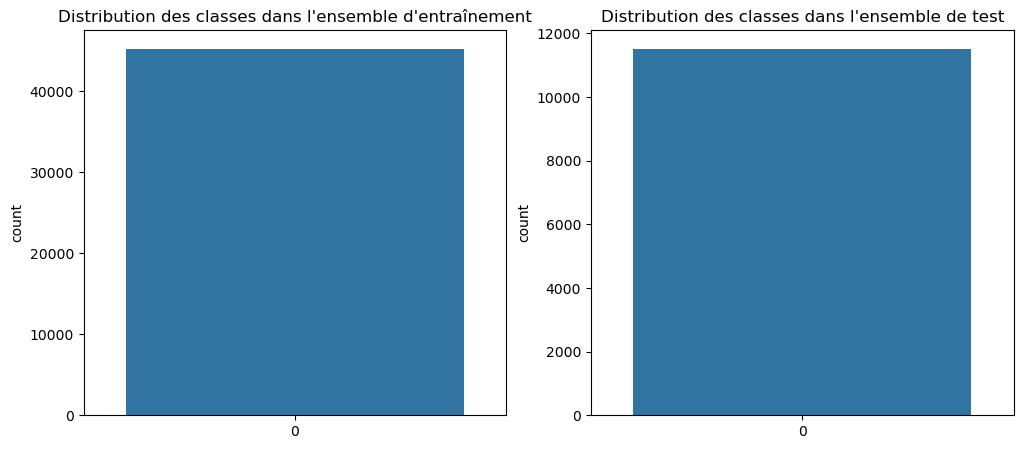

In [114]:
def plot_class_distribution(y_train, y_test):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(y_train, ax=ax[0])
    ax[0].set_title('Distribution des classes dans l\'ensemble d\'entraînement')
    sns.countplot(y_test, ax=ax[1])
    ax[1].set_title('Distribution des classes dans l\'ensemble de test')
    plt.show()


plot_class_distribution(Y_train, Y_test)

# *Matrice de confusion*

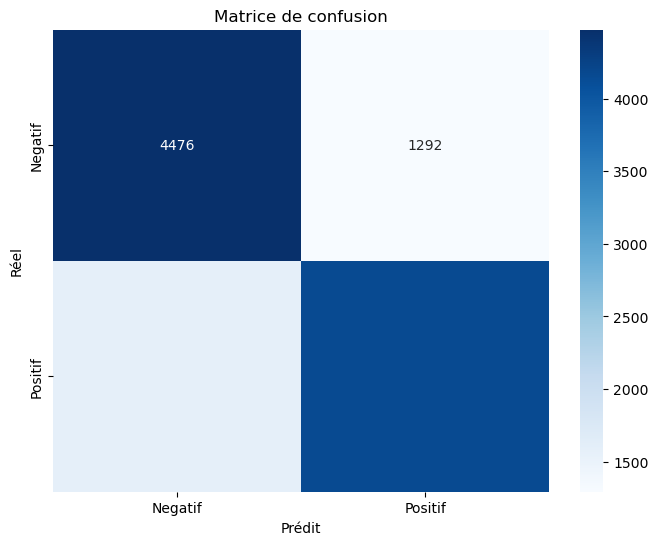

In [116]:
def plot_confusion_matrix(y_true, y_pred, title='Matrice de confusion'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])
    plt.ylabel('Réel')
    plt.xlabel('Prédit')
    plt.title(title)
    plt.show()

plot_confusion_matrix(Y_test, X_test_prediction)


# *Importance des termes*

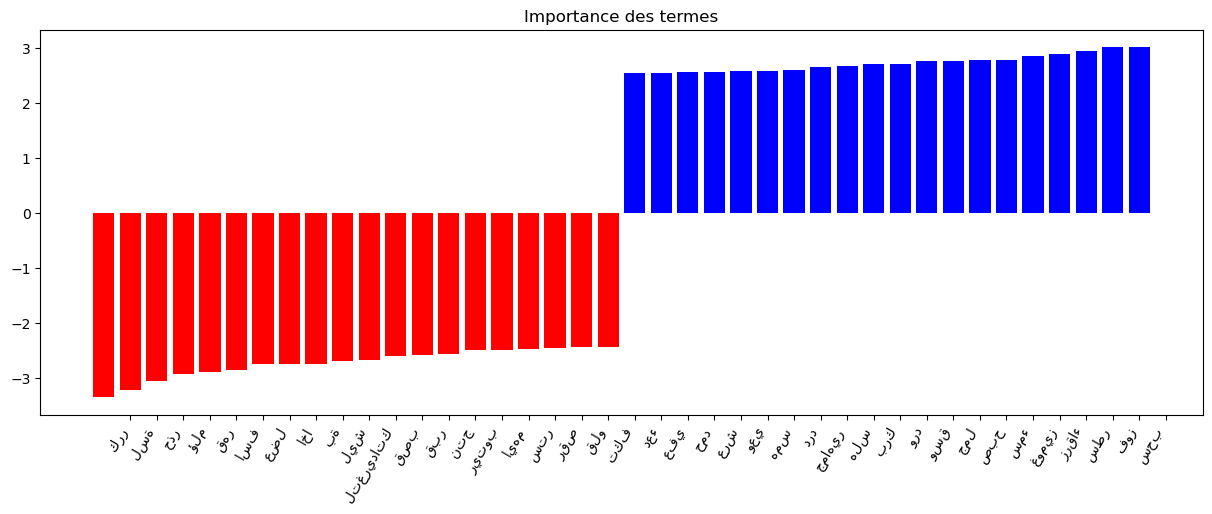

In [117]:
def plot_feature_importance(vectorizer, model, top_n=20):
    feature_names = vectorizer.get_feature_names_out()
    coef = model.coef_.flatten()
    top_positive_coefficients = np.argsort(coef)[-top_n:]
    top_negative_coefficients = np.argsort(coef)[:top_n]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_n), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_n), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title('Importance des termes')
    plt.show()  
    
    
plot_feature_importance(vectorizer, model)

# *Courbe ROC*

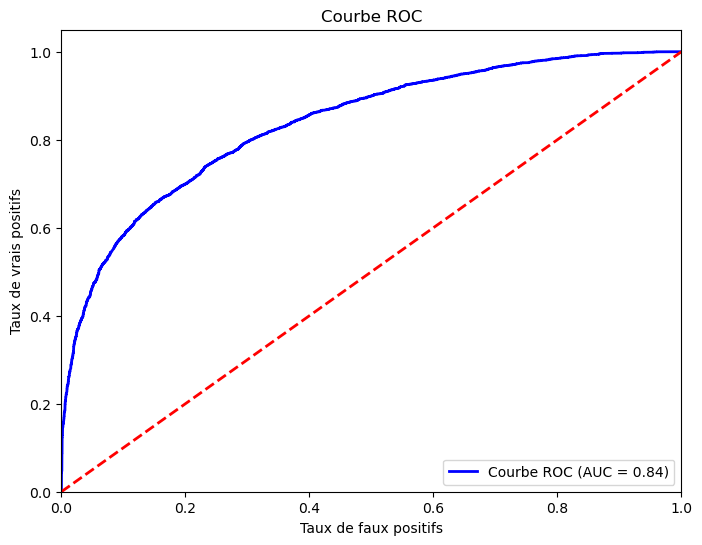

In [118]:
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='Courbe ROC (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de faux positifs')
    plt.ylabel('Taux de vrais positifs')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

y_pred_proba = model.predict_proba(X_test)[:, 1]
plot_roc_curve(Y_test, y_pred_proba)